In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Parameter settings",
TRAIN_DIR = 'dataset/train'
VAL_DIR   = 'dataset/val'
TEST_DIR  = 'dataset/test'

# Reduce image size to speed up training on CPU",
IMG_SIZE = (224, 224)

# Smaller batch to fit in limited RAM and work better on CPU",
BATCH_SIZE = 8

# Reduce epochs; we'll do a short fine-tune later",
EPOCHS = 30
FINE_TUNE_EPOCHS = 20

SAVE_DIR = 'models'
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11418 images belonging to 7 classes.
Found 1430 images belonging to 7 classes.


In [5]:
# Get number of classes
num_classes = train_generator.num_classes
class_names = train_generator.class_indices
print("Classes:", class_names)

Classes: {'cardboard': 0, 'e-waste': 1, 'glass': 2, 'medical': 3, 'metal': 4, 'paper': 5, 'plastic': 6}


In [6]:
import json
import csv


class_indices = train_generator.class_indices  # dictionary {class_name: index}
os.makedirs(SAVE_DIR, exist_ok=True)

json_path = os.path.join(SAVE_DIR, 'class_indices.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(class_indices, f, ensure_ascii=False, indent=2)

csv_path = os.path.join(SAVE_DIR, 'class_indices.csv')
with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['class_name', 'index'])
    # sort by index for consistent ordering
    for name, idx in sorted(class_indices.items(), key=lambda x: x[1]):
        writer.writerow([name, idx])

print(f"Saved class indices to: {json_path} and {csv_path}")

Saved class indices to: models\class_indices.json and models\class_indices.csv


In [7]:
# Compute simple class weights to handle imbalance
from collections import Counter
counts = Counter(train_generator.classes)
total = sum(counts.values())
class_weights = {i: total/(num_classes*counts[i]) for i in range(num_classes)}
print("Class weights:", class_weights)

Class weights: {0: 1.056439674315322, 1: 0.8482282148428795, 2: 1.0093705799151345, 3: 1.303871188763275, 4: 0.9861806875107963, 5: 0.9466876710057209, 6: 0.9555611348229978}


In [8]:
# Load MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

In [9]:
from tensorflow.keras.regularizers import l2
# Build the model (smaller head for faster CPU training)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [10]:
# Early stopping callback for better training
ckpt_path = os.path.join(SAVE_DIR, 'best_model.h5')
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

In [11]:
# Train the model
# Compute steps to stabilize training on generators (safe defaults)
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, val_generator.samples // BATCH_SIZE)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=False
)

Epoch 1/30
  10/1427 [..............................] - ETA: 15:07 - loss: 3.0500 - accuracy: 0.1375

c:\Users\ADMIN\trash-classifer\.env\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1427/1427 [==============================] - ETA: 0s - loss: 1.8415 - accuracy: 0.4062
Epoch 1: val_loss improved from inf to 0.95080, saving model to models\best_model.h5
1427/1427 [==============================] - 595s 413ms/step - loss: 1.8415 - accuracy: 0.4062 - val_loss: 0.9508 - val_accuracy: 0.6791 - lr: 1.0000e-04
Epoch 2/30
1427/1427 [==============================] - ETA: 0s - loss: 1.2801 - accuracy: 0.5731
Epoch 2: val_loss improved from 0.95080 to 0.77816, saving model to models\best_model.h5
1427/1427 [==============================] - 574s 401ms/step - loss: 1.2801 - accuracy: 0.5731 - val_loss: 0.7782 - val_accuracy: 0.7367 - lr: 1.0000e-04
Epoch 3/30
1427/1427 [==============================] - ETA: 0s - loss: 1.1253 - accuracy: 0.6279
Epoch 3: val_loss improved from 0.77816 to 0.70793, saving model to models\best_model.h5
1427/1427 [==============================] - 597s 418ms/step - loss: 1.1253 - accuracy: 0.6279 - val_loss: 0.7079 - val_accuracy: 0.7591 - lr: 1.0

In [12]:
# -------- Fine-tune top of backbone ----------
# Unfreeze some layers and fine-tune with lower LR if desired
base_model.trainable = True
# Freeze first N layers to keep low-level features
fine_tune_at = len(base_model.layers) - 50
for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= fine_tune_at else False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=False
)

Epoch 1/15
1427/1427 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6846
Epoch 1: val_loss did not improve from 0.48616
1427/1427 [==============================] - 831s 575ms/step - loss: 0.9449 - accuracy: 0.6846 - val_loss: 0.5310 - val_accuracy: 0.8371 - lr: 1.0000e-05
Epoch 2/15
1427/1427 [==============================] - ETA: 0s - loss: 0.8537 - accuracy: 0.7190
Epoch 2: val_loss did not improve from 0.48616
1427/1427 [==============================] - 822s 575ms/step - loss: 0.8537 - accuracy: 0.7190 - val_loss: 0.5369 - val_accuracy: 0.8315 - lr: 1.0000e-05
Epoch 3/15
1427/1427 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.7399
Epoch 3: val_loss did not improve from 0.48616
1427/1427 [==============================] - 822s 576ms/step - loss: 0.7960 - accuracy: 0.7399 - val_loss: 0.4862 - val_accuracy: 0.8483 - lr: 1.0000e-05
Epoch 4/15
1427/1427 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.7626
Epoch

In [14]:
# -------- Evaluate on test set ----------
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.4f}, loss: {loss:.4f}")

Found 1431 images belonging to 7 classes.
179/179 [==============================] - 62s 347ms/step - loss: 0.4420 - accuracy: 0.8721
Test accuracy: 0.8721, loss: 0.4420


In [15]:
# Save final model (h5 + SavedModel)
final_h5 = os.path.join(SAVE_DIR, 'waste_model_final(v2).h5')
model.save(final_h5)
print("Saved model to:", final_h5)

Saved model to: models\waste_model_final(v2).h5


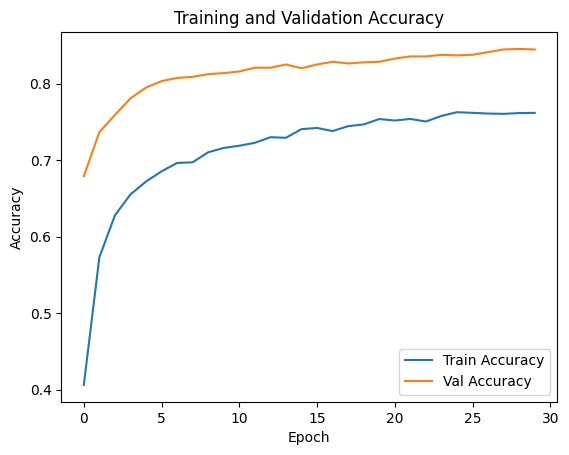

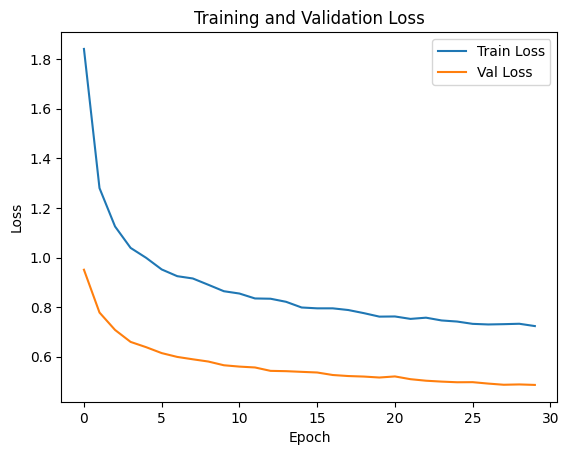

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

 30/179 [====>.........................] - ETA: 50s

c:\Users\ADMIN\trash-classifer\.env\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


179/179 [==============================] - 62s 344ms/step
              precision    recall  f1-score   support

   cardboard       0.87      0.93      0.90       193
     e-waste       0.96      0.88      0.92       241
       glass       0.83      0.93      0.87       203
     medical       0.83      0.85      0.84       157
       metal       0.88      0.90      0.89       207
       paper       0.87      0.83      0.85       216
     plastic       0.85      0.78      0.81       214

    accuracy                           0.87      1431
   macro avg       0.87      0.87      0.87      1431
weighted avg       0.87      0.87      0.87      1431

[[180   1   2   1   2   7   0]
 [  4 213   0  11   5   4   4]
 [  4   1 188   1   3   1   5]
 [  1   3   5 134   3   2   9]
 [  4   0   6   2 187   3   5]
 [  9   3   7   6   6 179   6]
 [  5   0  19   7   6  10 167]]
